# Candlestick Formation
In this notebook, we will take the data we have farmed via Bitfinex API and will be converting our data into candle-stick formation images. 

The very first part of this notebook will be to test the functionality with a small subset of the data. 

Then we will form both a window & label algorithm which will be used to create window images labelled for our classification task. 

Each window will be composed of 15, 30 min intervals which will be labeled according to the 20th (5 points preceeding our window) opening price. 

That is: 

```python
if open_of_20th > close_of_15th_by_3_percent:
    label = 'buy'
elif open_of_20th < close_of_15th:
    label = 'sell'
else:
    label = 'hold'
```

Given the nature of BTC/USD and most cryptocurrencies, labeling with aggresive moves may be a good strategy.

In fact, our labeling algorithm will greatly impact the overall trading strategy, thus we may revisit this in the future for optimization. 

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import gc

from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from time import sleep
import multiprocessing as mp

In [2]:
# Loading our data
file = './post_processing/btcusd_ohlc_2017_2019.csv'

headers = ['date', 'open', 'close', 'high', 'low', 'volume']
my_dtypes = {
    'date': 'str',
    'open': 'float',
    'close': 'float',
    'high': 'float',
    'low': 'float',
    'volume': 'float'
}

my_parse_dates = ['date']

df = pd.read_csv(file, header=0, names=headers, dtype=my_dtypes, parse_dates=my_parse_dates)

# Re-arranging columns for OHLC
df = df[['date', 'open', 'high', 'low', 'close', 'volume']]

In [3]:
df.head()

,date,open,high,low,close,volume
0,2017-01-01 05:00:00,962.98,963.00,962.11,962.98,29.466950
1,2017-01-01 05:30:00,962.90,965.20,962.56,964.88,61.575102
2,2017-01-01 06:00:00,963.90,964.95,962.72,962.83,27.068546
3,2017-01-01 06:30:00,963.49,967.45,963.36,967.45,78.595934
4,2017-01-01 07:00:00,966.48,967.41,966.48,966.67,21.279508


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40784 entries, 0 to 40783
Data columns (total 6 columns):
date      40784 non-null datetime64[ns]
open      40784 non-null float64
high      40784 non-null float64
low       40784 non-null float64
close     40784 non-null float64
volume    40784 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 1.9 MB


In [5]:
# CREATING SMALL SUBSET - given constraints of our machine, we will cut this down to 12,000 rows 
df = df.iloc[:12000]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 6 columns):
date      12000 non-null datetime64[ns]
open      12000 non-null float64
high      12000 non-null float64
low       12000 non-null float64
close     12000 non-null float64
volume    12000 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 562.6 KB


In [7]:
df.head()

,date,open,high,low,close,volume
0,2017-01-01 05:00:00,962.98,963.00,962.11,962.98,29.466950
1,2017-01-01 05:30:00,962.90,965.20,962.56,964.88,61.575102
2,2017-01-01 06:00:00,963.90,964.95,962.72,962.83,27.068546
3,2017-01-01 06:30:00,963.49,967.45,963.36,967.45,78.595934
4,2017-01-01 07:00:00,966.48,967.41,966.48,966.67,21.279508


In [8]:
df.tail()

,date,open,high,low,close,volume
11995,2017-09-08 03:00:00,4598.5,4604.0,4591.6,4603.9,172.298897
11996,2017-09-08 03:30:00,4604.0,4604.0,4591.2,4597.6,207.746482
11997,2017-09-08 04:00:00,4597.4,4604.0,4597.4,4603.9,204.296908
11998,2017-09-08 04:30:00,4604.0,4604.0,4564.1,4569.0,336.218156
11999,2017-09-08 05:00:00,4568.9,4589.6,4568.9,4588.0,157.140020


In [9]:
# Creating test df window - to test our candlestick formation
window_one = df.iloc[:15].copy()

In [10]:
# converting dates into floats for ohcl framework
window_one['date'] = [mdates.date2num(d) for d in window_one['date']]

In [11]:
window_one.head()

,date,open,high,low,close,volume
0,736330.208333,962.98,963.00,962.11,962.98,29.466950
1,736330.229167,962.90,965.20,962.56,964.88,61.575102
2,736330.250000,963.90,964.95,962.72,962.83,27.068546
3,736330.270833,963.49,967.45,963.36,967.45,78.595934
4,736330.291667,966.48,967.41,966.48,966.67,21.279508


In [12]:
# re-arrange and grab values
quotes = [tuple(x) for x in window_one[['date', 'open', 'high', 'low', 'close']].values]

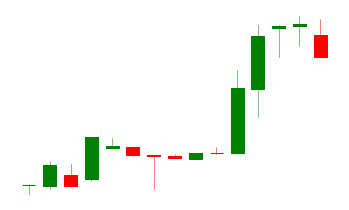

In [13]:
# Test plot
fig, ax = plt.subplots()
candlestick_ohlc(ax, quotes, width=0.013, colorup='g', colordown='r')

# hiding axis
plt.yticks([])
plt.xticks([])
plt.axis('off')

plt.gcf().autofmt_xdate()

# Labeling & Creating Images

In [4]:
# FUNCTIONS

def save_image(df, path):
    """
    df: Dataframe to create images
    path: path in which we will save the images
    """
    gc.disable()
    
    # instantiating 
    start_index = 0
    end_index = 15
    label_index = 20
    img_index = 1
    
    for i in tqdm(range(len(df))):
        
        try:

            # Creating our window
            window_df = df.iloc[start_index:end_index]
            
            # grabbing close of 15th day
            day_15_close = window_df.iloc[-1]['close']
            
            # Calculating 2% increase
            one_percent_increase = day_15_close + (day_15_close * 0.01)
            
            # Converting window_df into quotes for OHCL
            quotes = [tuple(x) for x in window_df[['date','open','high','low','close']].values]
            
            # Plot candlestick.
            fig, ax = plt.subplots()
            candlestick_ohlc(ax, quotes, width=0.013, colorup='g', colordown='r')

            # hiding x, y values
            plt.yticks([])
            plt.xticks([])
            plt.axis('off')

            plt.gcf().autofmt_xdate()
            
            # Labelling 
            
            # BUY
            if df.iloc[label_index]['open'] > one_percent_increase:
                
                # Saving buy
                label = 'Buy'
                plt.savefig(f'{path}/{img_index}.{label}.png', dpi=100)
                
                # Clearing memory
                plt.close('all')
                plt.clf()
                plt.cla()
                fig.clf()

                # Increase image index
                img_index += 1
            
            # SELL
            elif df.iloc[label_index]['open'] < day_15_close:
                
                # Sell
                label = 'Sell'
                plt.savefig(f'{path}/{img_index}.{label}.png', dpi=100)
                
                # Clearing memory
                plt.close('all')
                plt.clf()
                plt.cla()
                fig.clf()

                # Increase image index
                img_index += 1
                
            # HOLD
            else:
                
                # Hold
                label = 'Hold'
                plt.savefig(f'{path}/{img_index}.{label}.png', dpi=100)
                
                
                # Clearing memory
                plt.close('all')
                plt.clf()
                plt.cla()
                fig.clf()

                # Increase index
                img_index += 1
                
            # Coutning up index
            start_index += 1
            end_index += 1
            label_index += 1
            
            if i % 500 == 0:
                sleep(5)
                gc.collect()
                sleep(5)

            
        except Exception:
            pass
        
        
    # finished
    print('Finished')
    

# Worker Function
def worker(df_):
    save_path = f'{os.curdir}/model_data/images_unscattered'
    save_image(df_, save_path)

In [5]:
# converting our dates into floats for OHLC
df['date'] = [mdates.date2num(d) for d in df['date']]

In [6]:
# Clearing some memory
gc.collect()

0

100%|█████████▉| 11998/12000 [44:01<00:00, 16.51it/s]/Users/diegomedina-bernal/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
100%|██████████| 12000/12000 [44:01<00:00, 16.98it/s]

Finished


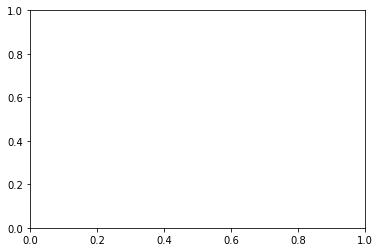

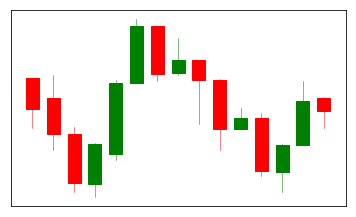

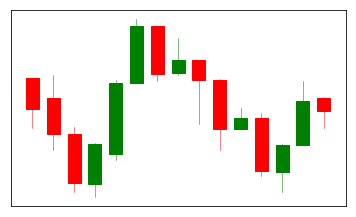

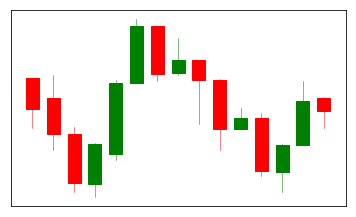

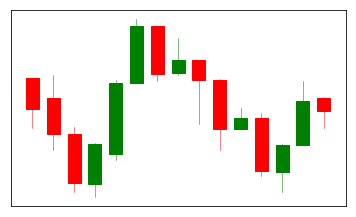

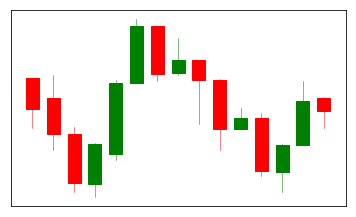

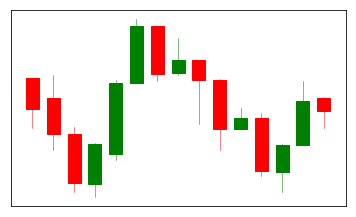

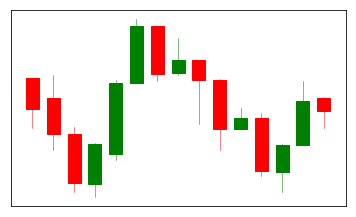

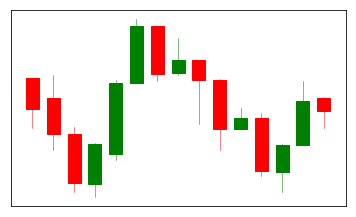

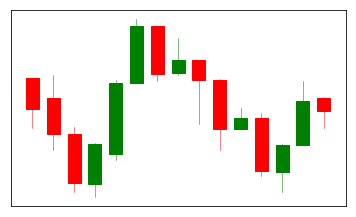

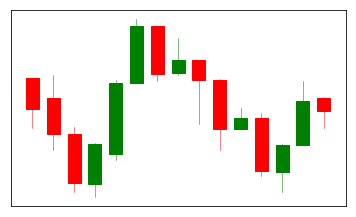

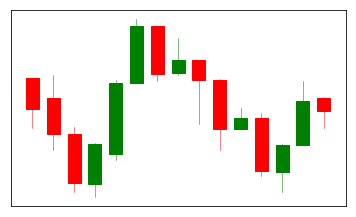

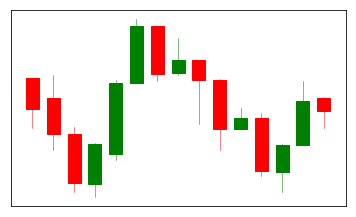

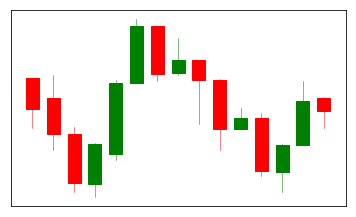

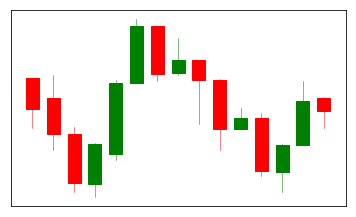

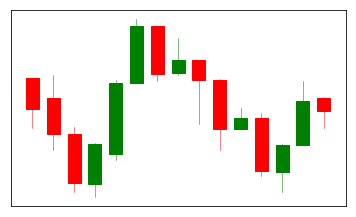

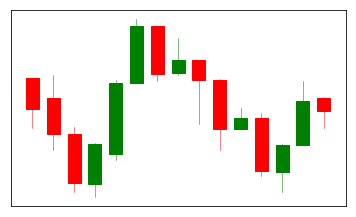

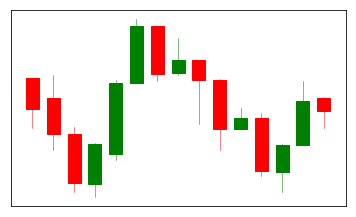

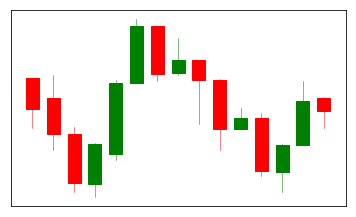

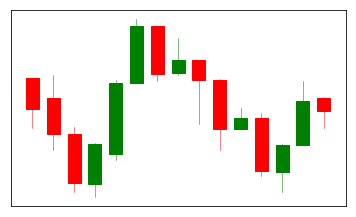

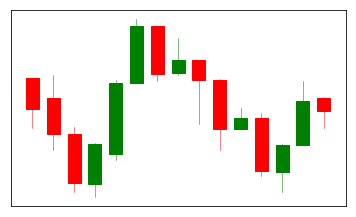

In [8]:
# Saving images using multi-processing
if __name__ == "__main__":
    proc = mp.Process(target=worker(df)) # our worker function with our df
    proc.deamon = True
    proc.start()
    proc.join()